# Titanic: Machine Learning from Disaster

"This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: **use machine learning to create a model that predicts which passengers survived the Titanic shipwreck."**

https://www.kaggle.com/c/titanic/overview

## Objetivo

Criar um modelo de machine learning para prever os passageiros sobreviventes no desastre do Titanic

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Gathering Data

In [2]:
df = pd.concat([pd.read_csv('dataset/train.csv'), pd.read_csv('dataset/test.csv')], ignore_index=True, sort=True)

# Data preparation

### Data Description

| Variable | Definition                                 | Key                                            |   |
|----------|--------------------------------------------|------------------------------------------------|---|
| survival | Survival                                   | 0 = No, 1 = Yes                                |   |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |   |
| sex      | Sex                                        |                                                |   |
| Age      | Age in years                               |                                                |   |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |   |
| parch    | # of parents / children aboard the Titanic |                                                |   |
| ticket   | Ticket number                              |                                                |   |
| fare     | Passenger fare                             |                                                |   |
| cabin    | Cabin number                               |                                                |   |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |   |

In [3]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Removendo algumas variáveis

#### Ticket
A estrutura de cada dado está confusa não possuem um padrão aparente. Por isso, está coluna também será excluída

In [4]:
df = df.drop(['Ticket'], axis=1)

#### Cabin
A variável Cabin possui certa relevância para o dataset, pois, a inicial de cada cabine indica em qual [andar do návio](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png) o passageiro estava hospedado, podendo influenciar na hora da fuga do mesmo. Mas, por estar faltando cerca de 77% dos dados dessa coluna, também optei por removê-lá. 

In [5]:
1 - (df['Cabin'].count() / len(df['Cabin'])) # % de dados faltando

0.774637127578304

In [6]:
df = df.drop(['Cabin'], axis=1)

### Manipulando a variável Name
A variável Name contém dados importantes sobre cada passageiro, pois pode indicar, por exemplo, o estado cívil do passageiro, 'Miss' para mulheres solteiras e 'Mrs.' para mulheres casadas. Ou Até mesmo, o status social, como por exemplo, 'Dr', 'Major', 'Don' e etc.

In [7]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [8]:
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Jonkheer      1
Dona          1
Countess      1
Don           1
Mme           1
Sir           1
Capt          1
Lady          1
Name: Title, dtype: int64

<br />
Como alguns títulos aparecem muito raramente, irei combinalos em uma categoria só.
<br /><br />

In [9]:
others = [title for title in df['Title'].unique() if title not in ['Mr', 'Miss', 'Mrs', 'Master']]
df['Title'] = df['Title'].replace(others, 'Others')

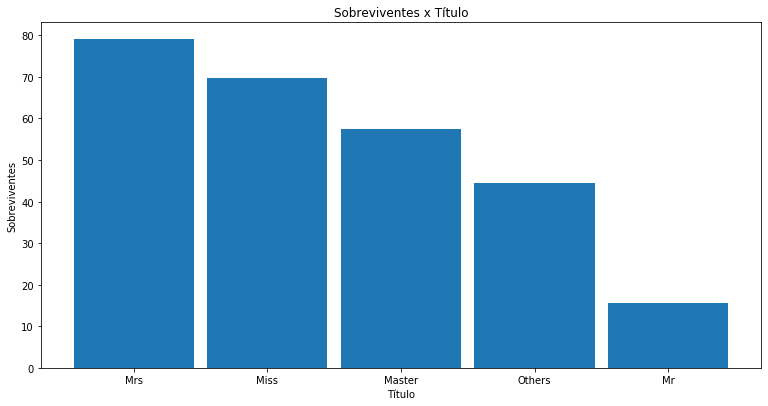

In [10]:
p = df[['Title', 'Survived']].groupby(by='Title').sum()
p['%'] = p['Survived'] / df[['Title', 'Survived']].groupby(by='Title').count()['Survived'] * 100
p = p.sort_values(by='%', ascending = False)

fig = plt.figure(figsize=(10, 4.8))
ax = fig.add_axes([0,0,1,1])
ax.bar(p.index, p['%'], 0.9)
plt.ylabel('Sobreviventes')
plt.xlabel('Título')
plt.title('Sobreviventes x Título')
plt.show()

### Convertendo variáveis categóricas

In [11]:
df['Title'] = df['Title'].map({"Mr": 1, "Others": 2, "Master": 3, "Miss": 4, "Mrs": 5}) # De nominal para variável ordinal
df = pd.concat([df, pd.get_dummies(df['Sex']), pd.get_dummies(df['Embarked'])], axis=1) # Para variável dummy

In [12]:
df.drop(['Sex', 'Embarked', 'Name'], axis=1, inplace=True)

### Imputação de variáveis

In [13]:
df['Age'] = pd.DataFrame(SimpleImputer().fit_transform(df['Age'].values.reshape(-1,1)))
df['Fare'] = pd.DataFrame(SimpleImputer().fit_transform(df['Fare'].values.reshape(-1,1)))

In [14]:
df.isnull().sum()

Age              0
Fare             0
Parch            0
PassengerId      0
Pclass           0
SibSp            0
Survived       418
Title            0
female           0
male             0
C                0
Q                0
S                0
dtype: int64

### Separando os dados de treino e test
Removendo também a coluna PassengerId para evitar problemas de Overfitting

In [42]:
train = df[df.Survived.notna()]
test = df[df.Survived.isnull()]

X_train = train.drop(["Survived", 'PassengerId'], axis=1)
y_train = train["Survived"]

X_test = test.drop(["Survived", 'PassengerId'], axis=1)

# Criando modelos

Como temos um problema de aprendizado de máquina supervisionado, irei testar alguns modelos e ver qual tem o melhor resultado

In [43]:
def ml(model):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    return model.score(X_train, y_train)

scores = {}

## Árvore de decisão

In [44]:
from sklearn.tree import DecisionTreeClassifier

scores['Árvore de Decisão'] = ml(DecisionTreeClassifier())

## Regressão logística

In [45]:
from sklearn.linear_model import LogisticRegression

scores['Regressão logística'] = ml(LogisticRegression(solver='liblinear'))

### KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

scores['KNN'] = ml(KNeighborsClassifier(n_neighbors = 3))

## Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB

scores['Naive Bayes'] = ml(GaussianNB())

In [51]:
models = pd.DataFrame({
    'Modelo': list(scores.keys()),
    'Score': list(scores.values())})
models.set_index('Modelo', inplace=True)
models.sort_values(by='Score', ascending=False)

,Score
Modelo,
Árvore de Decisão,0.984287
KNN,0.858586
Regressão logística,0.819304
Naive Bayes,0.796857


# Salvando resultados

In [52]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = [int(y) for y in decision_tree.predict(X_test)]

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)